# Classificação de texto
Criaremos modelos de classificação de texto com base em 4 níveis de dificuldade, utilizando o dataset que contém textos escritos por estudantes do Ensino Fundamental I, Ensino Fundamental II, Ensino Médio e Ensino Superior.

In [1]:
import pandas as pd
import numpy as np

## Leitura dos dados

In [23]:
# Create pre-processed dataset from the folders
%run src/create_dataset.py

In [24]:
# Read dataset into Pandas DataFrame
df = pd.read_csv('dataset.csv', index_col='id')
df.head()

,text,label
id,,
207_765,"nada impede, no entanto, que sejam substituído...",1
232_790,e muitas palavras faladas por esses povos fora...,1
39_347,"sete séculos antes do nascimento de cristo, o ...",1
48_379,voar sempre foi um dos grandes sonhos da human...,1
73_629,"para os bolsos de seus senhores, é claro. você...",1


In [4]:
shape = df.shape
print(f'DataFrame has {shape[0]} rows and {shape[1]} columns.')
print('DataFrame has {:s}missing data!'.format('no ' if not df['text'].isna().any() else ''))
print('DataFrame has {:s}duplicates!'.format('no ' if not df.index.duplicated().any() else ''))

DataFrame has 2076 rows and 2 columns.
DataFrame has no missing data!
DataFrame has duplicates!


In [5]:
print('Removing duplicates...')
df = df[~df.index.duplicated()]

Removing duplicates...


In [6]:
df.groupby(['label']).count()

,text
label,
1,297
2,325
3,627
4,826


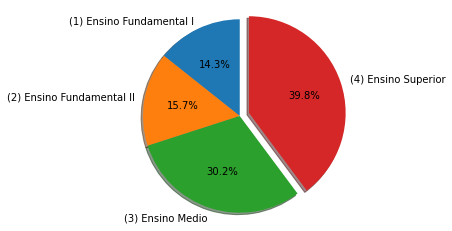

In [7]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = df.groupby(['label']).count().values.ravel()
labels = ['(1) Ensino Fundamental I', '(2) Ensino Fundamental II', '(3) Ensino Medio', '(4) Ensino Superior']
explode = (0, 0, 0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('figures/class-distribution.png', dpi=200)
plt.show()

## Divisão do dataset

In [8]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

## Transformação do dataset

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [10]:
import nltk
nltk.download('punkt')
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/caio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /home/caio/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /home/caio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/caio/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [11]:
!python -m spacy download pt

⚠ As of spaCy v3.0, shortcuts like 'pt' are deprecated. Please use the
full pipeline package name 'pt_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 8.9 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [12]:
def print_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')
    matrix = pd.DataFrame(conf_matrix, columns=[1, 2, 3, 4], index=[1, 2, 3, 4])
    print(matrix.round(2))

In [13]:
class CustomPortugueseLemmatizer():
    """Canonicalize a dataset by applying lemmatization to texts
    in the portuguese language with Spacy's "pt_core_news_sm" module
    """
    def __init__(self):
        import spacy
        self.nlp = spacy.load("pt_core_news_sm")
    
    # Returns True if the word is in CV (consonant-vowel) format or False if it is not
    def is_canonical(self, word):
        canonical = True
        seq = iter(word)

        for c in seq:
            if c not in 'bcdfghjklmnpqrstvwxyzç':
                canonical = False
                break
            else:
                try:
                    n = next(seq)
                except StopIteration as e:
                    canonical = False
                    break
                if n not in 'aeiouáàãâéêíóõôúü':
                    canonical = False
                    break
        return canonical
    
    def remove_case(self, token):
        return (
            token.is_stop 
            or any(c.isdigit() for c in token.text) 
            or token.pos_ == 'PUNCT' 
            or token.pos_ == 'NUM' 
            or token.pos_ == 'SPACE' 
            or token.pos_ == 'SYM' 
            or token.pos_ == 'X'
               )
    
    def fit(self, raw_documents, y=None):
        return self
    
    def transform(self, raw_documents):
        X = []
        for text in raw_documents:
            word_list = []
            cv_list = []
            for token in self.nlp(text):
                # only append useful words, excluding stop words, numbers, 
                # spaces, punctuations, symbols and unknown characters
                if not self.remove_case(token): 
                    word = token.lemma_.lower()
                    word_list.append(word)
                    # assign if word is in CV (consonant-vowel) format or if it is not defined
                    # word = word + '_cv' if is_canonical(word) else word + '_nd'
                    cv_list.append('is_cv' if self.is_canonical(word) else 'not_cv')

            sentence = ' '.join(word_list)
            sentence += ' '
            sentence += ' '.join(cv_list)
            X.append(sentence)
        return X
    
    def fit_transform(self, raw_documents, y=None):
        return self.fit(raw_documents, y).transform(raw_documents)

In [15]:
lem = CustomPortugueseLemmatizer()
lem = lem.fit(X_train, y_train)
X_train_trans = lem.transform(X_train)

count_vect = CountVectorizer()
count_matrix = count_vect.fit_transform(X_train_trans)
count_array = count_matrix.toarray()

tfidf_trans = TfidfTransformer()
tfidf_matrix = tfidf_trans.fit_transform(count_matrix)
tfidf_array = tfidf_matrix.toarray()
tfidf_df = pd.DataFrame(data=tfidf_array, columns = count_vect.get_feature_names())
tfidf_df.head()

,a_f,a_i,a_n,aan,aapt,aatp,ab,abacate,abacaxi,abaixar,...,ρdv,ρdz,ρrt,ρv,ρva,ρρ,ρρv,ρψ,ωr,मकष
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print('Frequência de palavras canônicas')
print(tfidf_df['is_cv'])

Frequência de palavras canônicas
0       0.067681
1       0.102084
2       0.122346
3       0.059515
4       0.093320
          ...   
1551    0.038875
1552    0.105381
1553    0.087607
1554    0.014886
1555    0.020574
Name: is_cv, Length: 1556, dtype: float64


## Modelos de classificação

In [17]:
# Create Pipeline to automatically vectorize and transform the input data before classifying
pipeNB = Pipeline([('lemmatizer', CustomPortugueseLemmatizer()), 
                    ('vectorizer', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()), 
])

# Multinomial Naive Bayes

pipeNB = pipeNB.fit(X_train, y_train)

predictions_NB = pipeNB.predict(X_test)

print('Naive Bayes Normalized Confusion Matrix')
print_confusion_matrix(y_test, predictions_NB)
print()
print(classification_report(y_test, predictions_NB, digits=2, zero_division=0))

Naive Bayes Normalized Confusion Matrix
     1    2     3     4
1  0.0  0.0  0.45  0.55
2  0.0  0.0  0.18  0.82
3  0.0  0.0  0.60  0.40
4  0.0  0.0  0.01  0.99

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        74
           2       0.00      0.00      0.00        93
           3       0.61      0.60      0.61       134
           4       0.56      0.99      0.72       218

    accuracy                           0.57       519
   macro avg       0.29      0.40      0.33       519
weighted avg       0.39      0.57      0.46       519



In [18]:
# Create Pipeline to automatically vectorize and transform the input data before classifying
pipeSVC = Pipeline([('lemmatizer', CustomPortugueseLemmatizer()), 
                    ('vectorizer', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC(C=1.0, random_state=21)),
])

# Linear Support Vector Classifier

pipeSVC = pipeSVC.fit(X_train, y_train)

predictions_SVC = pipeSVC.predict(X_test)

print('Linear SVC Normalized Confusion Matrix')
print_confusion_matrix(y_test, predictions_SVC)
print()
print(classification_report(y_test, predictions_SVC, digits=2, zero_division=0))

Linear SVC Normalized Confusion Matrix
      1     2     3     4
1  0.89  0.04  0.07  0.00
2  0.08  0.76  0.14  0.02
3  0.00  0.01  0.90  0.09
4  0.00  0.00  0.02  0.98

              precision    recall  f1-score   support

           1       0.90      0.89      0.90        74
           2       0.95      0.76      0.85        93
           3       0.84      0.90      0.87       134
           4       0.94      0.98      0.96       218

    accuracy                           0.91       519
   macro avg       0.91      0.88      0.89       519
weighted avg       0.91      0.91      0.91       519



## Classificando um novo texto

In [19]:
# Retrieve the last text from the test set
text = X_test.iloc[-1]
print(text)

português/morfologia(2)  modernamente, observamos que os alunos de 1º e 2º graus utilizam gramáticas em seu estudo da língua, mas para nossa preocupação, essas não possuem, quase sempre, base científica por não se basearem em estudos lingüísticos. é importante para nós que um estudo gramatical tenha uma relevância lingüística e, por isso, resolvemos fazer um trabalho que mostre o atual conteúdo de morfologia estudado nas escolas e uma alternativa de conteúdo mais racional, embasado em princípios científicos. inicialmente, proporemos um conceito de morfologia, passando à diferença entre vocábulo e palavra, uma vez que tais termos são usados indistintamente pelos gramáticos, chegando, enfim, ao problema crucial: o que são classes e o que são funções dos vocábulos ?  o objetivo deste trabalho é aprofundar teorias científicas que justifiquem uma alteração significativa no conteúdo ministrado, hoje, no estudo morfológico, tornando o ensino gramatical mais racional e científico. é também obj

In [20]:
# Create list of texts to predict
X_eval = [text]
label_NB = pipeNB.predict(X_eval)
label_SVC = pipeSVC.predict(X_eval)

print(f'Naive Bayes label: {label_NB}')
print(f'SVC label: {label_SVC}')
print(f'Correct label: {y_test[-1]}')

Naive Bayes label: [3]
SVC label: [3]
Correct label: 3


## Salvar modelos em pickle

In [22]:
import pickle
import os

path = 'pickle'
if not os.path.isdir(path):
    os.mkdir(path)

# Save Naive Bayes pipeline to pickle
with open(f'{path}/pipeline_NB.pickle', 'wb') as nb_pickle:
    pickle.dump(pipeNB, nb_pickle)

# Save SVC pipeline to pickle
with open(f'{path}/pipeline_SVC.pickle', 'wb') as svc_pickle:
    pickle.dump(pipeSVC, svc_pickle)